# Gene conservation of associated genes

Analayze how well conserved are the associated gene

In [1]:
import os
import pandas as pd

### Common functions

Some common functions used in all the steps of analysis

In [10]:
def get_data_paths(home_dir = '../data/'):
    '''
    Returns a dictionary object with the paths to data used in the notebook
    '''
    
    data_paths = dict(genomes_path = os.path.join(home_dir, 'patric_entero/genomes'),
                     conserved_genes_path = os.path.join(home_dir, 'pangenome_analysis/gene_conservation/'),
                     bbh_data_path = os.path.join(home_dir, 'pangenome_analysis/clb_vs_all_ecoli/tgt'))
    
    return data_paths


def get_table_paths(home_dir = '../tables/pangenome_analysis/'):
    '''
    Returns a dictionary object with the paths to tables used in the notebook
    '''
    
    table_paths = dict(asso_genes = os.path.join(home_dir, 'df_asso_genes_patric.csv'),
                      homolog_pid = os.path.join(home_dir, 'homology_map_df.csv'))
                     
    return table_paths


def get_pickle_paths(home_dir = '../pickles/'):
    '''
    Returns a dictionary object with the paths to tables used in the notebook
    '''
    
    pickle_paths = dict(pks_genome_colors = os.path.join(home_dir, 'pks_ecoli_genome_colors.p'))
    
                     
    return pickle_paths


def get_dataframes(table_paths):
    '''
    Returns dataframes for homolgy map and associated genes
    '''
    
    df_asso_genes = pd.read_csv(table_paths['asso_genes'], index_col= 'Unnamed: 0')
    df_homolog_pid = pd.read_csv(table_paths['homolog_pid'], index_col= 'Unnamed: 0')
    
    return df_asso_genes, df_homolog_pid

    
data_paths = get_data_paths()
table_paths = get_table_paths() 
pickle_paths = get_pickle_paths()
df_asso_genes, df_homolog_pid = get_dataframes(table_paths)

In [3]:
def get_asso_region(df_asso_genes, region_no):
    '''
    Select a list of genes from a particular group of associated genes, e.g. T6SS
    '''
    
    return df_asso_genes[df_asso_genes.region_number == region_no].index.tolist()


def slice_homolog_region(df_homolog_pid, df_asso_genes, region_no):
    '''
    Returns a slice of dataframe for genes of interest alone
    '''
    
    selected_genes = get_asso_region(df_asso_genes, region_no)
    df_homolog_pid_region = df_homolog_pid.loc[selected_genes, :]
    
    return df_homolog_pid_region

# Some of the important regions
# Region 1 : genes encoding Yfc fimbrial chaperone system
# Region 5 : genes encodin Fructose metabolism
# Region 7 : genes encoding TBP aldolase
# Region 10 : genes encoding T6SS system
#  Region 13 : genes encoding Arginine metabolism
# Region 18 : genes encoding D-threonate

region_ids = range(1, 19)

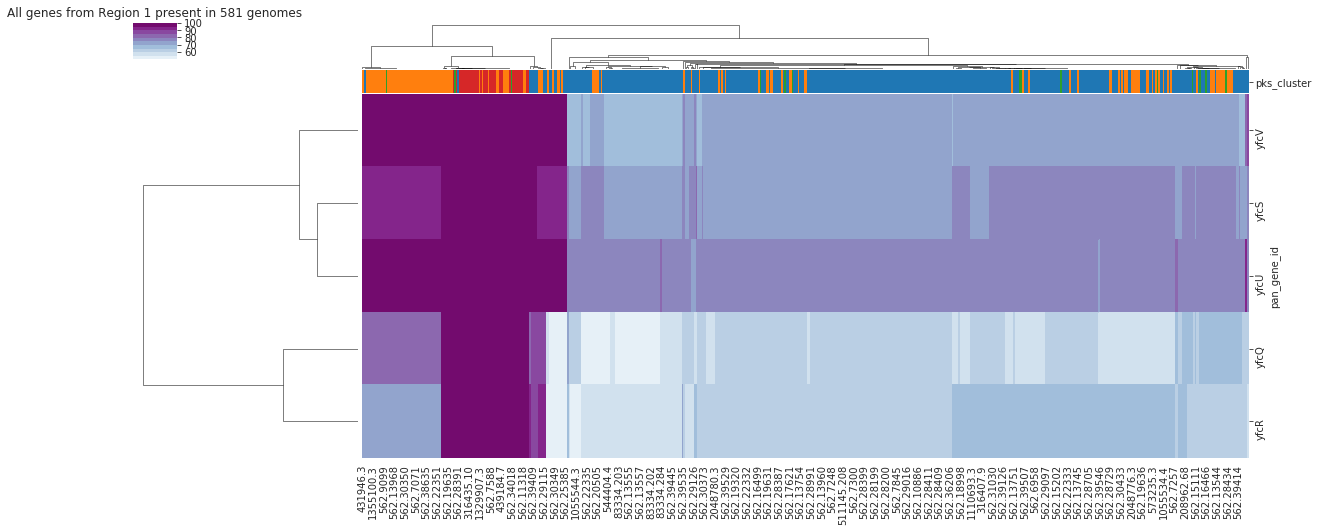

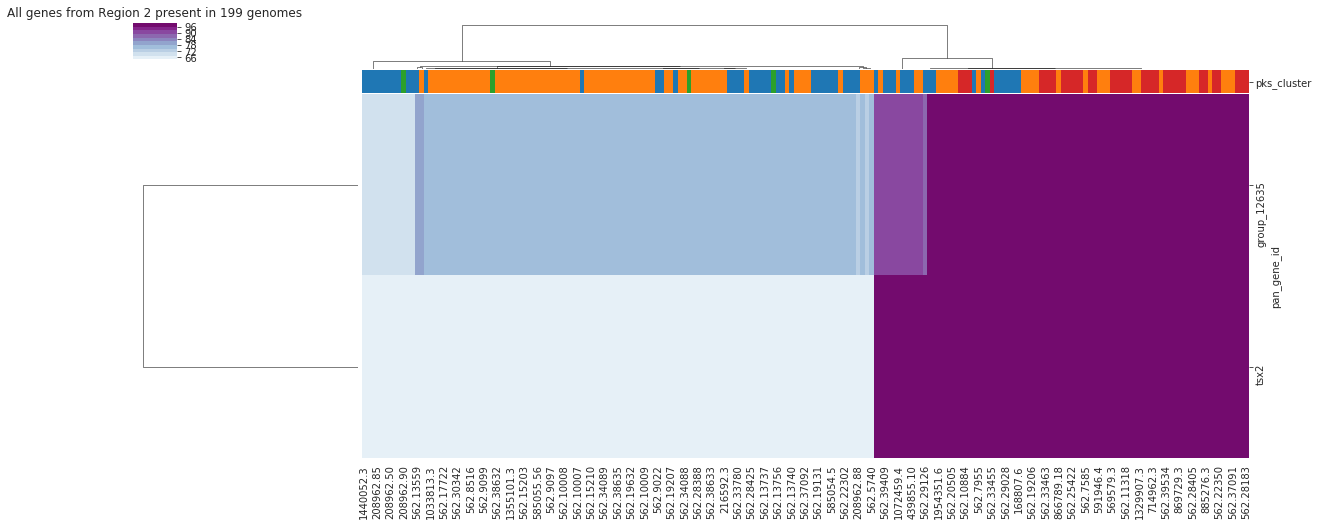

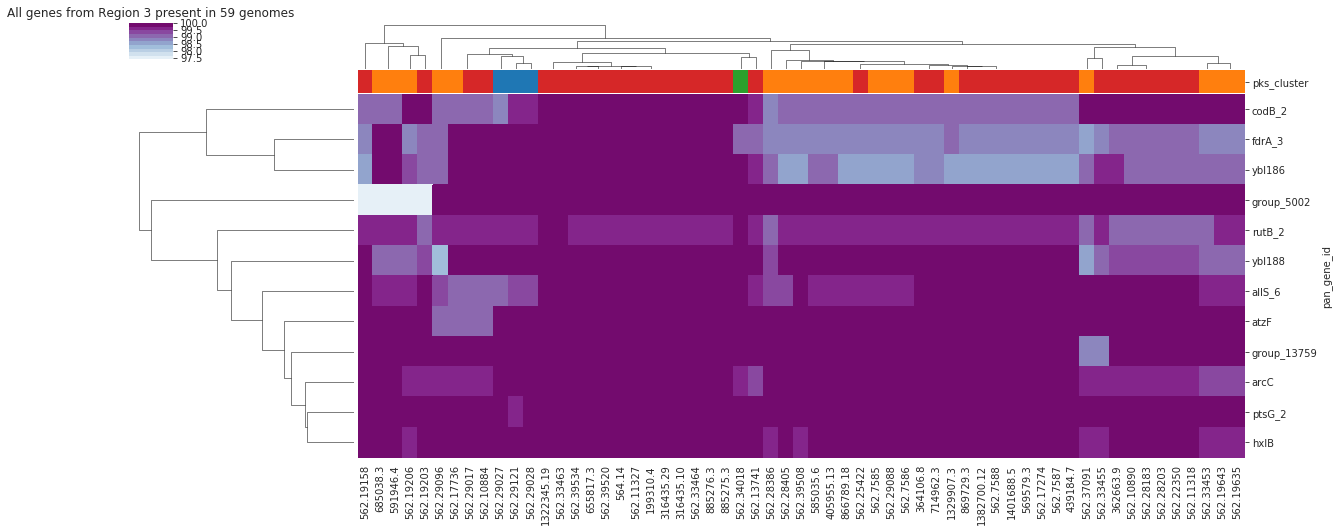

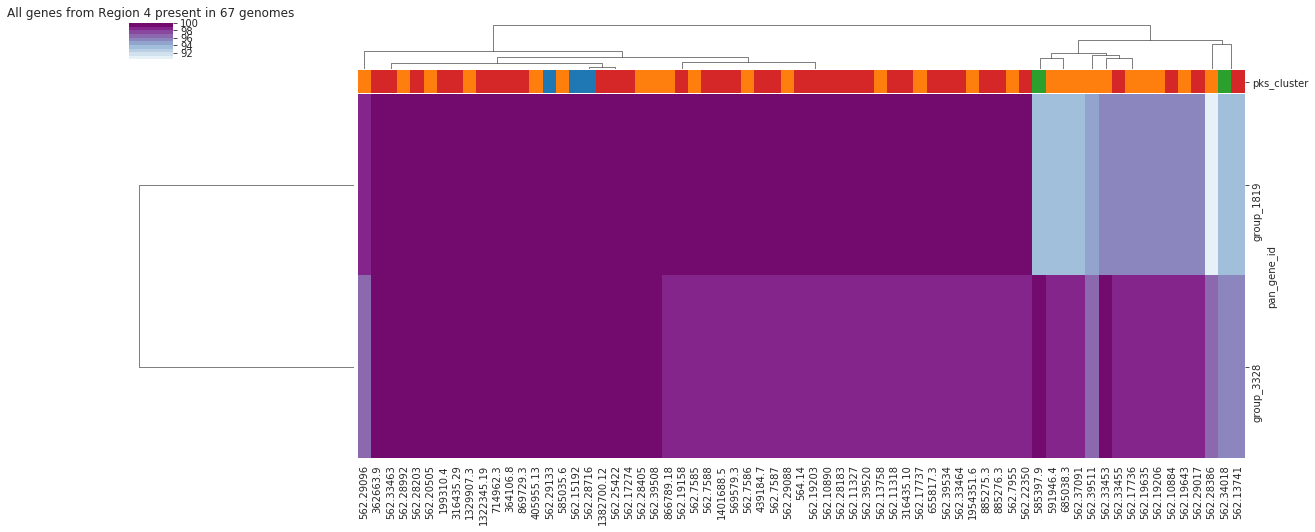

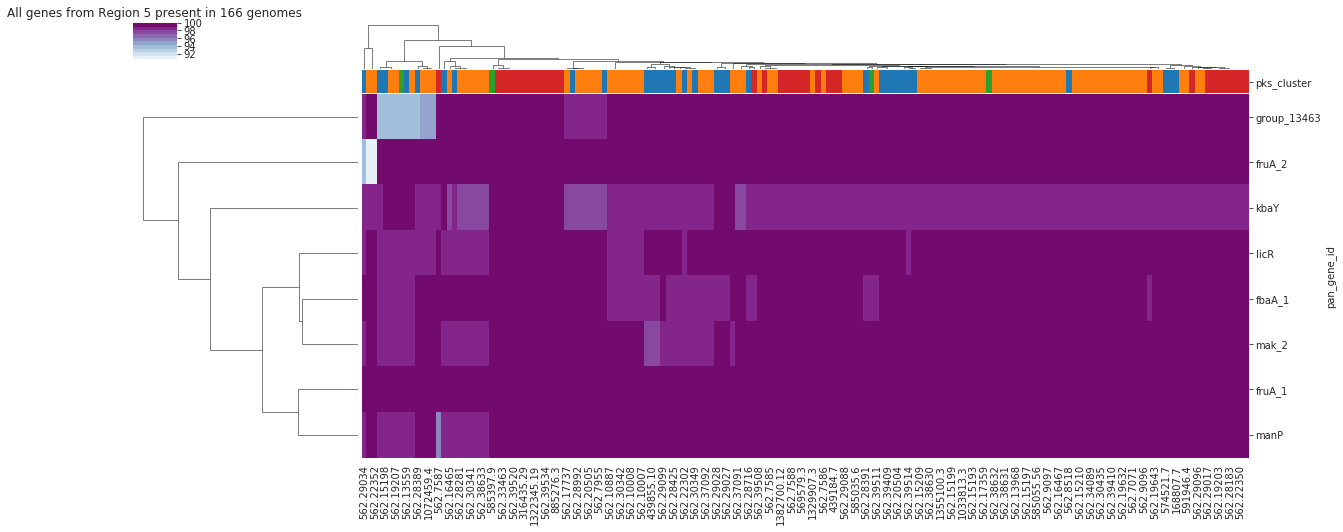

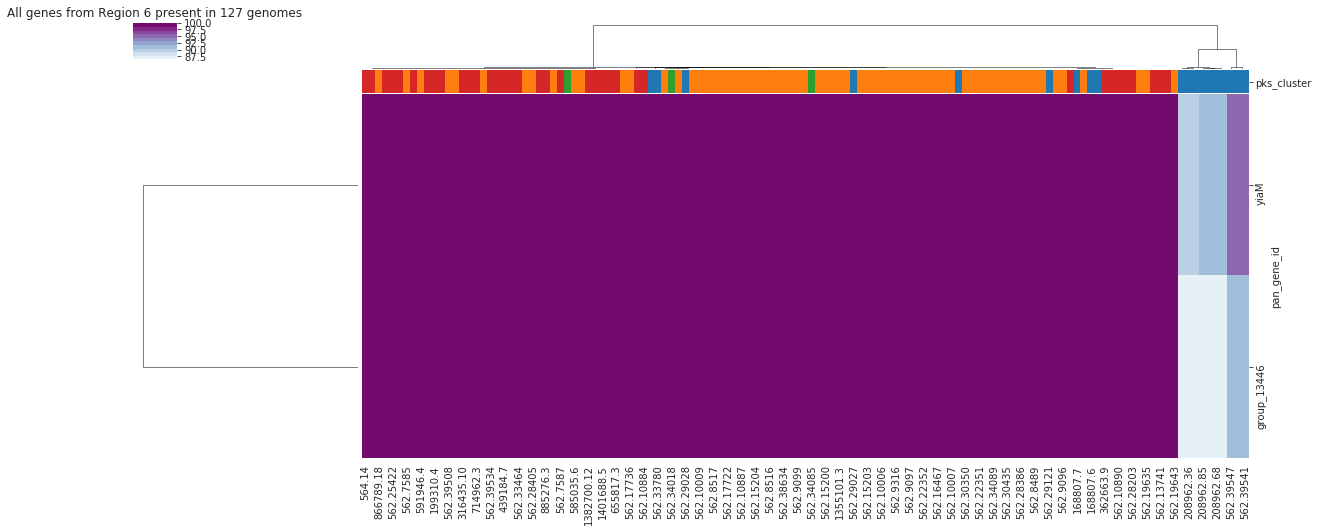

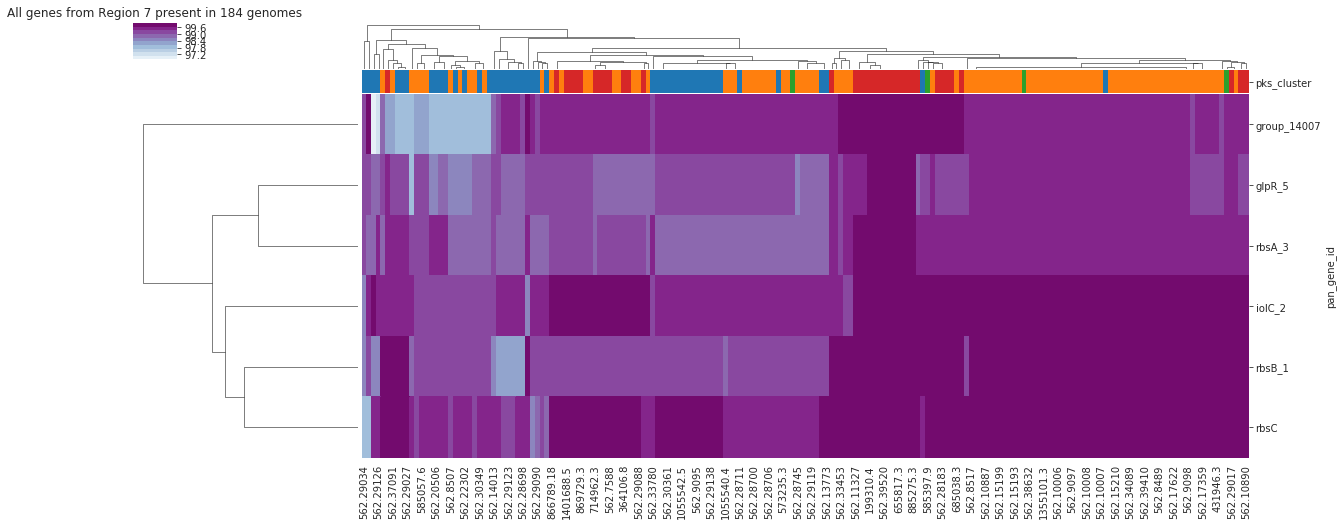

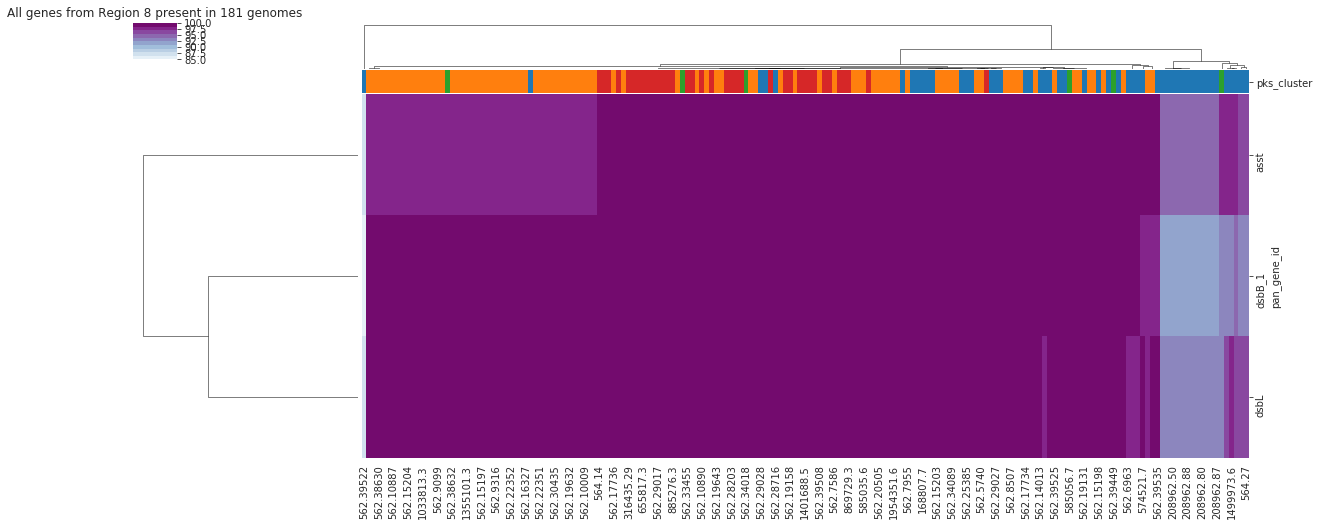

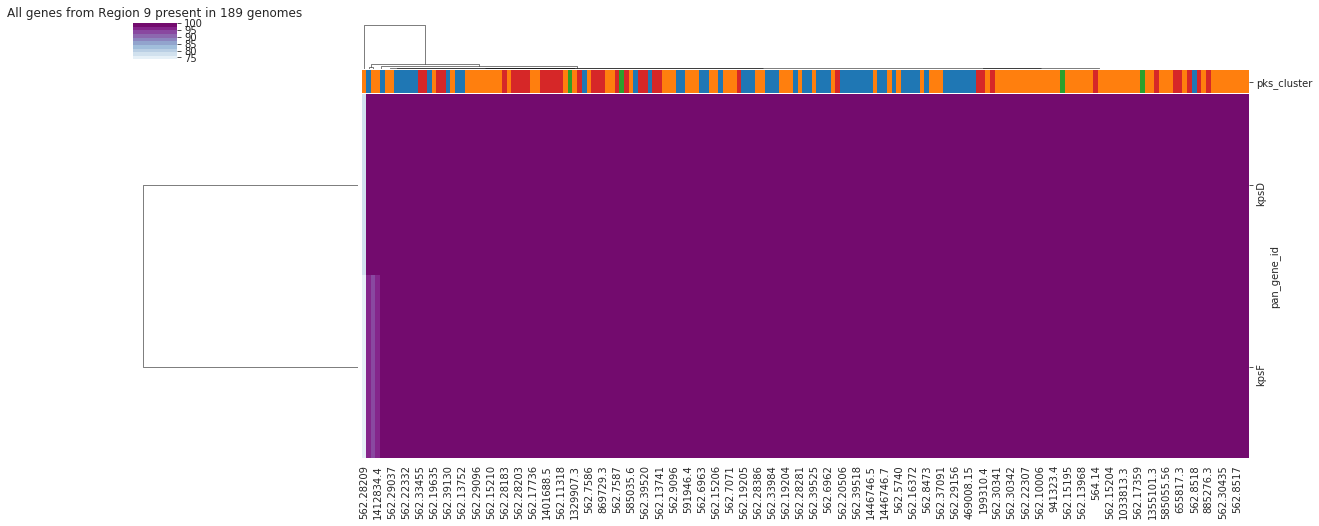

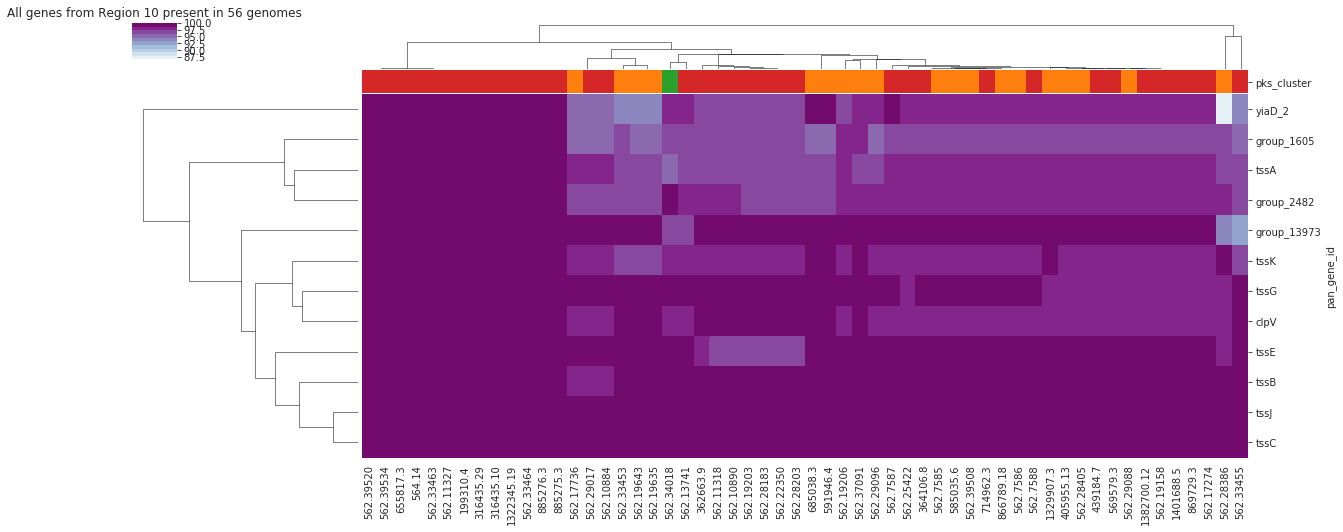

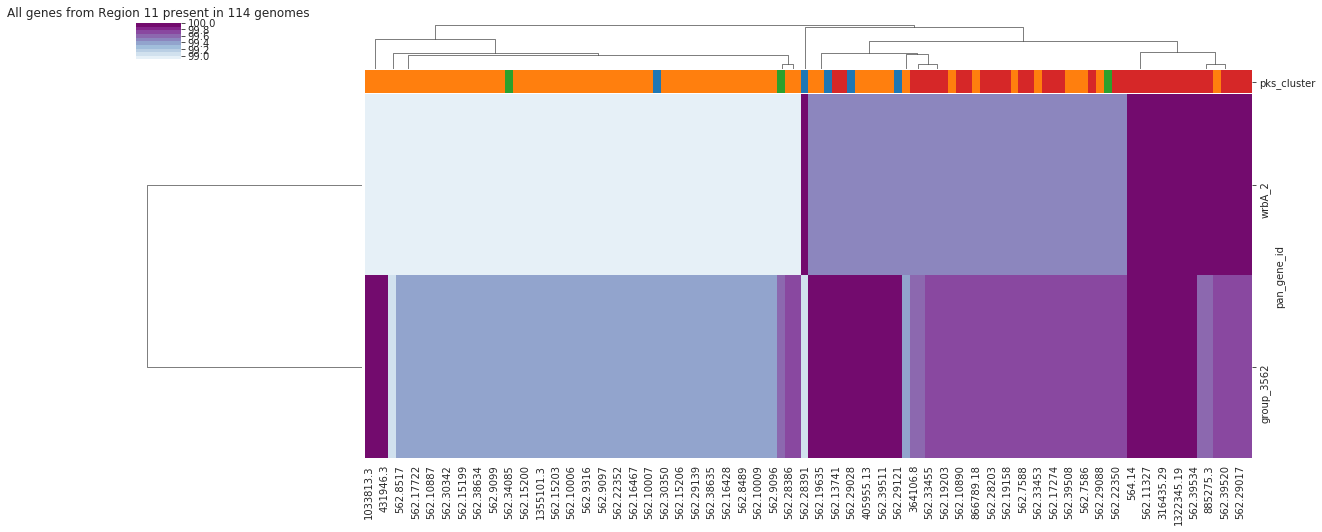

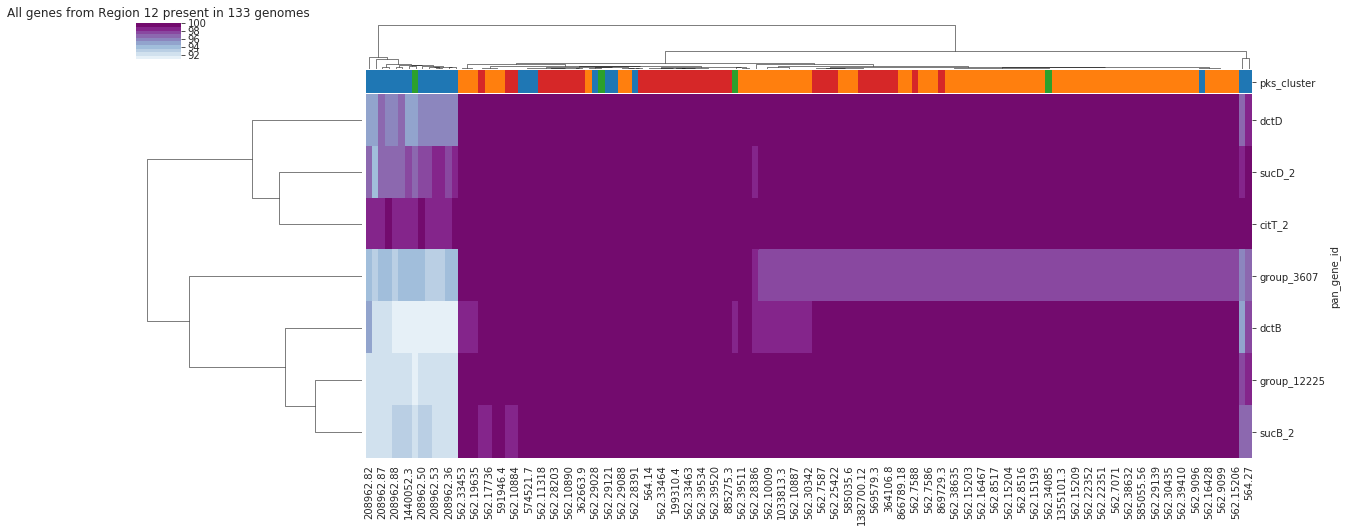

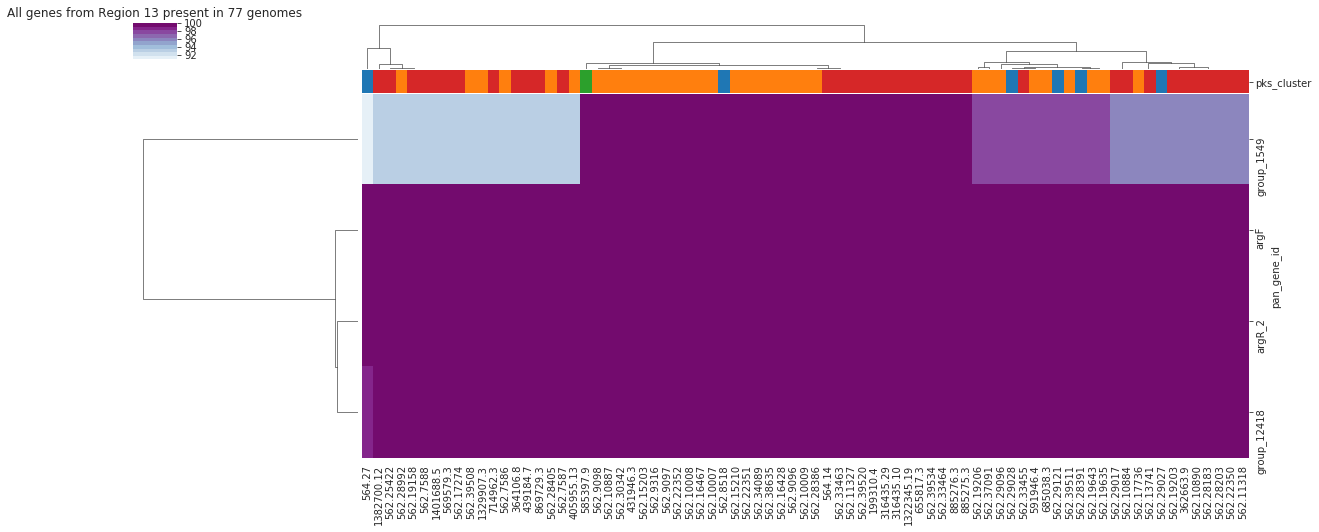

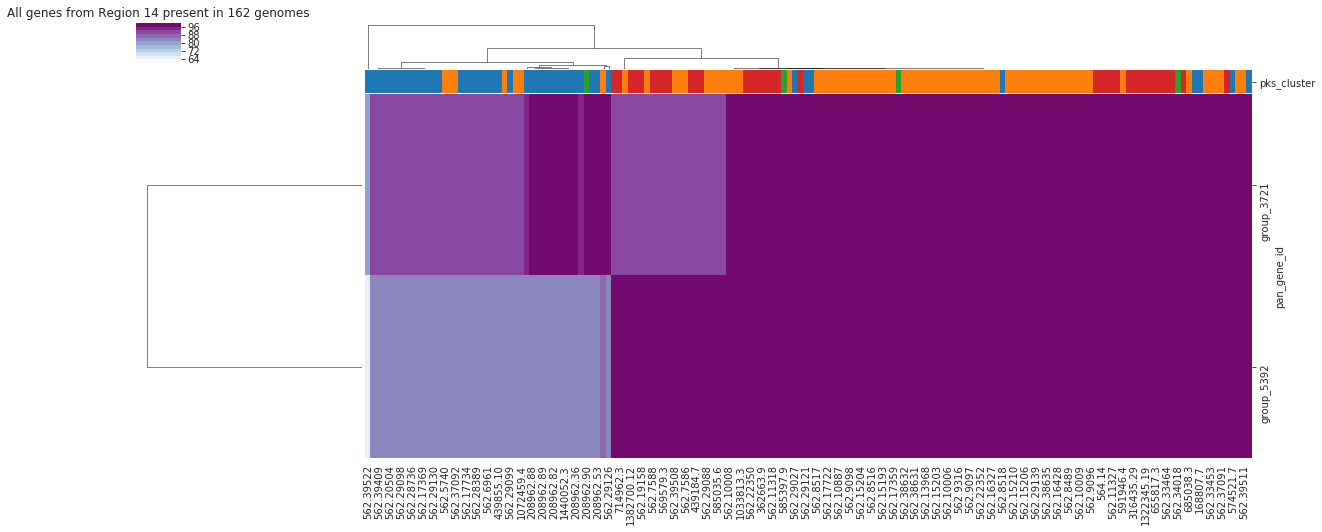

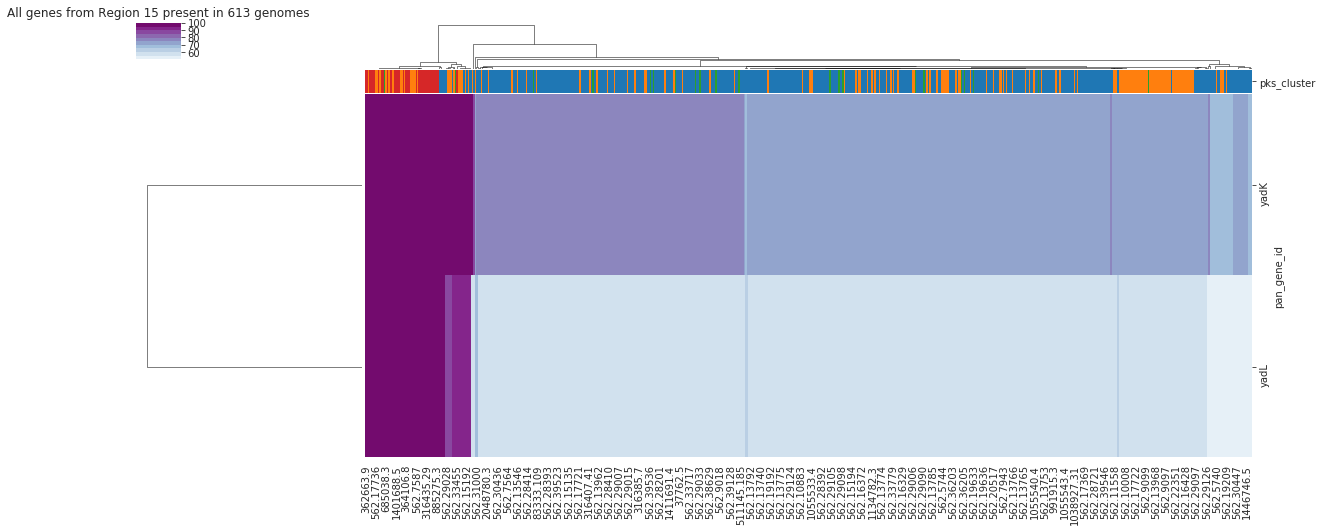

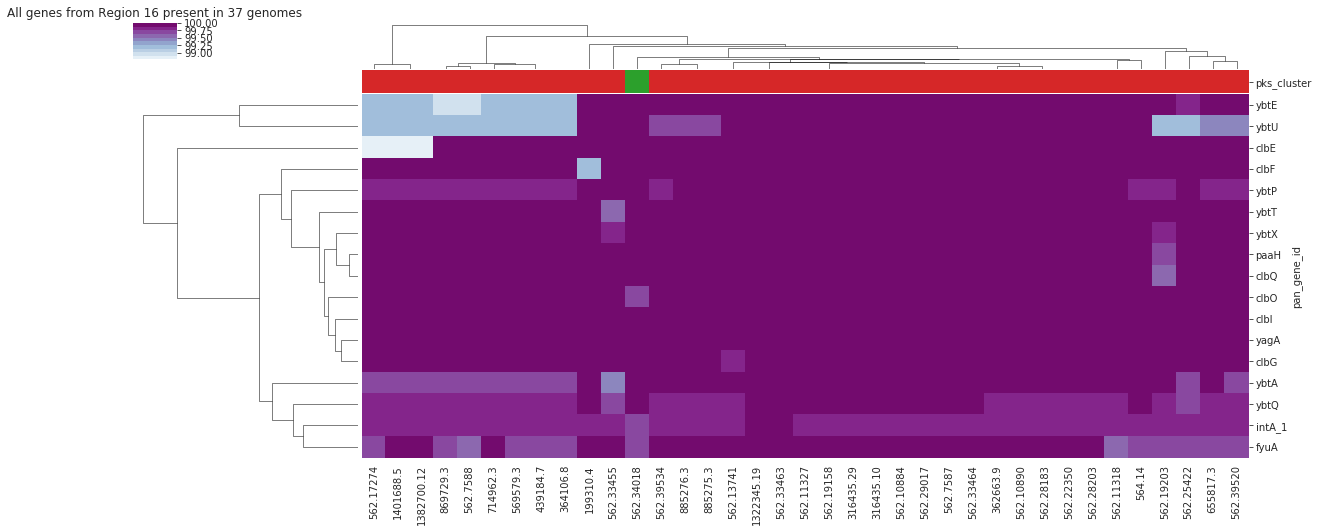

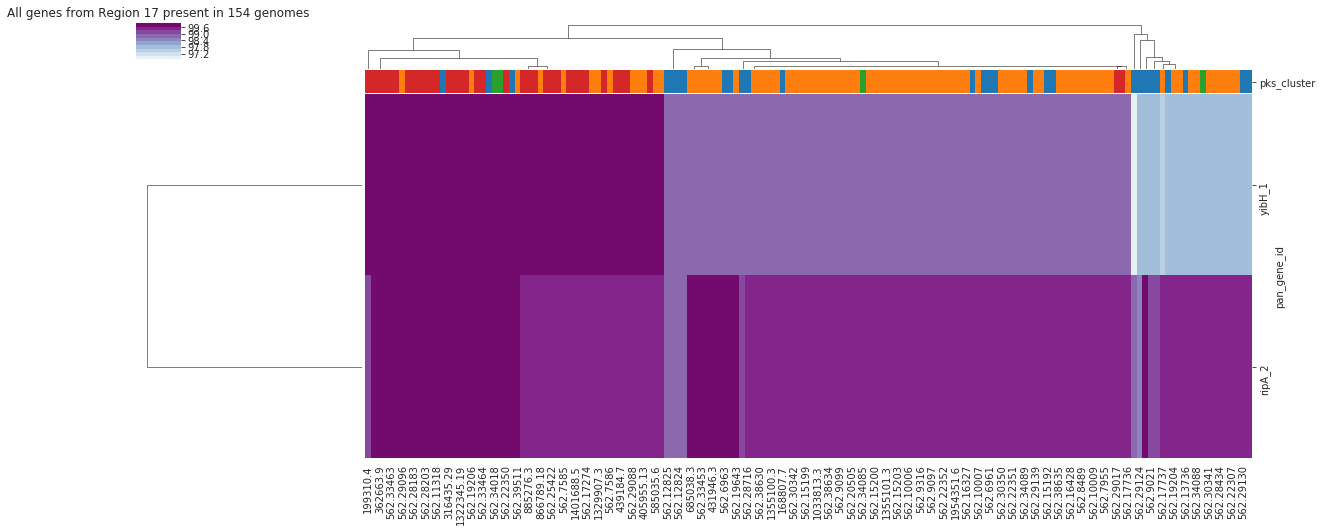

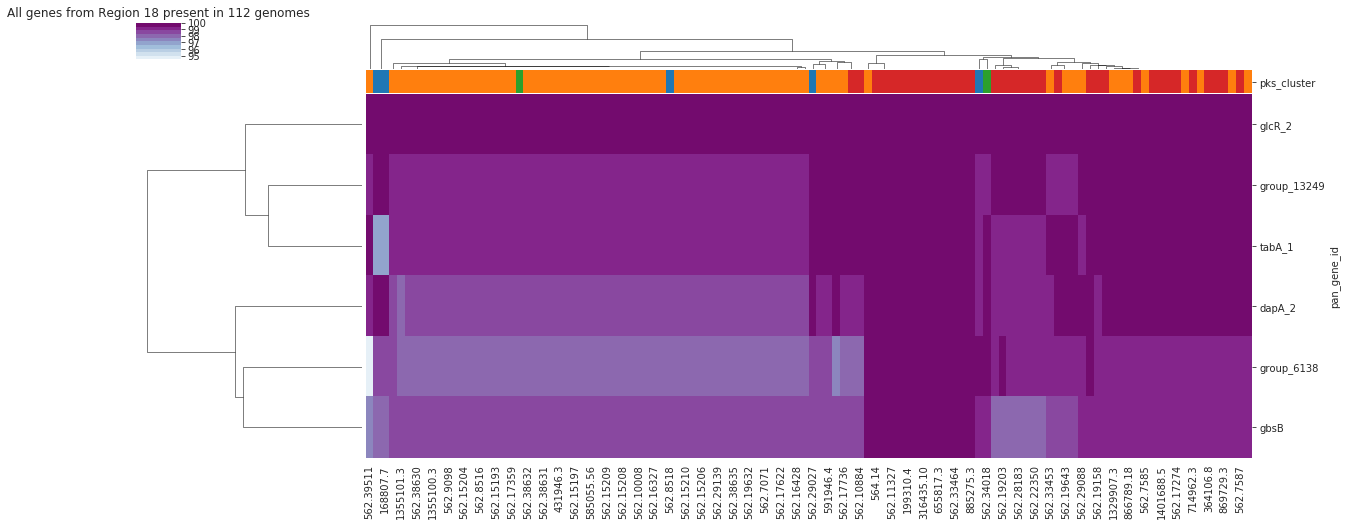

In [8]:
def get_genomes_with_region(df_homolog_pid_region, bbh_cutoff):
    '''
    Returns a list of all genomes having all the genes from asssociated region 
    '''

    df_homolog_pid_region_bool = df_homolog_pid_region > bbh_cutoff
    df_homolog_pid_region_bool = df_homolog_pid_region_bool * 1
    df_homolog_genes_region = df_homolog_pid_region.loc[:, df_homolog_pid_region_bool.sum(axis=0) == 
                                                        df_homolog_pid_region.shape[0]]
    
    return df_homolog_genes_region


def get_col_colors(pickle_paths, df_homolog_pid_region_genomes):
    '''
    Returns a dataframe descibing color scheme for columns based on known PKS cluster
    '''
    
    genome_pks_colors = pd.read_pickle(pickle_paths['pks_genome_colors'])
    
    return genome_pks_colors[df_homolog_pid_region_genomes.columns]


def plot_pid_region(df_homolog_pid_region_genomes, df_asso_genes, col_colors, fig_path,title_str):
    '''
    Plot heatmap of pid from BBH analysis for region of genes and genomes
    '''
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set_style('white')
    df_homolog_plot = df_homolog_pid_region_genomes.copy()

    df_homolog_plot.index = df_asso_genes.loc[df_homolog_plot.index, 'pan_gene_id']
    sns.clustermap(df_homolog_plot, cmap = sns.color_palette("BuPu",10), col_colors = col_colors, 
                           figsize=(20,8))
    plt.title(title_str)
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    

def plot_pid_main(region_ids, df_homolog_pid, df_asso_genes, pickle_paths):
    '''
    Main function to plot pid distribution of regions
    '''

    for region_no in region_ids:
        df_homolog_pid_region = slice_homolog_region(df_homolog_pid, df_asso_genes, region_no) 
        df_homolog_pid_region_genomes = get_genomes_with_region(df_homolog_pid_region, bbh_cutoff = 50)
        col_colors = get_col_colors(pickle_paths, df_homolog_pid_region_genomes)
        fig_path = '../figures/raw/region_bbh_dist/region_' + str(region_no) + '_pid_distribution.png'
        title_str = 'All genes from Region ' + str(region_no)+ ' present in ' + str(df_homolog_pid_region_genomes.shape[1]) + ' genomes'
        plot_pid_region(df_homolog_pid_region_genomes, df_asso_genes, col_colors, fig_path, title_str)
        
plot_pid_main(region_ids, df_homolog_pid, df_asso_genes, pickle_paths)

In [19]:
def get_best_homolog_ids(df_homolog_pid, gene_id_list, data_paths, bbh_cutoff):
    '''
    Returns dataframe with homolog gene with highest PID score
    '''
    
    bbh_data_path = data_paths['bbh_data_path']
    df_homolog_genes = pd.DataFrame(index=gene_id_list, columns=df_homolog_pid.columns)
    for gene_id in df_homolog_genes.index:
        genome_ids_gene = df_homolog_pid.columns[df_homolog_pid.loc[gene_id,:] > bbh_cutoff]
        
        for pat_id in genome_ids_gene:
            bbh_path = os.path.join(bbh_data_path, pat_id, 'blastp_tempGenome_against_targetGenome_parsed.txt')
            df_tmp_bbh = pd.read_table(bbh_path, header=None)
            df_tmp_bbh = df_tmp_bbh[df_tmp_bbh[0] == gene_id]
            df_tmp_bbh.sort_values(by=5, ascending=False)
            print(df_tmp_bbh.iloc[0,1])

            
            
#             for homolog in tgt_gene_homologs
#             if ',' in tgt_gene_homologs:
#                 tgt_gene_homologs = tgt_gene_homologs.replace("\'", "")
#                 tgt_gene_homologs_list = tgt_gene_homologs.split(',')
#             else:
#                 tgt_gene_homologs_list = [tgt_gene_homologs]
                
#             print(tgt_gene_homologs_list)
            
#             df_homolog_genes.loc[gene_id, pat_id] = tgt_gene_homologs_list
        
#     return df_homolog_genes


# def get_gene_alignment(gene_id, df_homolog_genes, data_paths):
#     '''
#     Returns multiple sequence alignment data to the given path
#     '''
    
#     conserved_genes_path = data_paths['conserved_genes_path']
#     gene_align_path = os.path.join(conserved_genes_path, 'alignments', gene_id)
    
#     if not os.path.isdir(gene_align_path):
#         os.mkdir(gene_align_path)
    
gene_id_list = ['fig|1322345.19.peg.265|DR76_253']
df_homolog_genes = get_best_homolog_ids(df_homolog_pid, gene_id_list, data_paths, bbh_cutoff = 50)

fig|83333.117.peg.2394|DHB4_11780
fig|544404.4.peg.3268|ECSP_3209
fig|1358422.3.peg.2480|PCN061_2434
fig|562.29130.peg.4448
fig|511145.183.peg.2409
fig|562.39141.peg.3838
fig|511145.185.peg.1260|EO53_06175
fig|562.39137.peg.1280
fig|562.15205.peg.4601|BE933_26535
fig|562.29100.peg.273
fig|562.7955.peg.3898|MJ49_19140
fig|562.29131.peg.2516
fig|562.13557.peg.3465|BFL24_17245
fig|562.28409.peg.2412
fig|562.36257.peg.28|DQ225_00085
fig|585035.6.peg.2465|ECS88_2482
fig|208962.89.peg.4665
fig|941323.4.peg.2650|ECVR50_2555
fig|498388.3.peg.1449|B6N50_07315
fig|562.17622.peg.1550|CCL28_07765
fig|562.36206.peg.1388
fig|562.9096.peg.2761|AVR72_13545
fig|1248823.7.peg.3151|ECRM12581_15300
fig|562.39128.peg.4475
fig|562.39448.peg.3642
fig|562.28398.peg.2418
fig|562.10009.peg.2168|A4R37_10585
fig|562.29121.peg.2010
fig|562.39453.peg.1432|EPB33_06920
fig|562.7071.peg.2703|SY51_13315
fig|562.12830.peg.3188|BBP24_15695
fig|562.13768.peg.3310|RG71_16190
fig|562.8489.peg.1826|AUO99_09695
fig|562.17727.

fig|562.7214.peg.2400|ECRV308_02335
fig|562.31031.peg.1363|NCTC9967_01376
fig|562.19206.peg.1785|CNQ47_08745
fig|595496.3.peg.2312|BWG_2108
fig|562.13552.peg.3430|BFL22_17025
fig|562.13741.peg.611|RG41_03010
fig|714962.3.peg.2666|ECOK1_2616
fig|562.39125.peg.4573
fig|562.39546.peg.1392|NCTC9064_01400
fig|562.17737.peg.2693|ACJ76_12675
fig|562.28706.peg.1936
fig|562.29106.peg.5322
fig|562.13737.peg.1754|RG27_08840
fig|83333.118.peg.2664|C3026_13000
fig|562.12924.peg.1537|BHW76_07565
fig|562.39112.peg.2478|EJP76_12015
fig|83334.203.peg.1572|A4C51_07720
fig|562.13750.peg.1521|RG31_07600
fig|208962.50.peg.2402|EACBF_2246
fig|562.39441.peg.4683
fig|1322345.19.peg.265|DR76_253
fig|562.16325.peg.4551|AM440_23220
fig|562.39129.peg.3371
fig|701177.3.peg.2904|G2583_2871
fig|316435.10.peg.2737|ECOLIN_13055
fig|562.28745.peg.3618
fig|562.39531.peg.1370|NCTC9087_01365
fig|562.13555.peg.3510|BFL16_17465
fig|562.29108.peg.2275
fig|562.30341.peg.4306|DLJ64_21730
fig|562.9097.peg.2481|AVR74_12135
fig|8

fig|562.19203.peg.1737|CNQ55_08665
fig|562.16427.peg.3434|AWH44_17040
fig|562.39447.peg.3632
fig|1045010.15.peg.1670
fig|168807.7.peg.2602|E2348_C_2474
fig|562.13958.peg.2409
fig|562.9857.peg.1670|ARC77_07985
fig|562.39413.peg.1388|ELE40_06710
fig|562.10887.peg.4167|WM90_20395
fig|562.19207.peg.1647|CNQ56_08230
fig|562.28414.peg.2417
fig|316401.27.peg.2692|ETEC_2470
fig|562.22333.peg.978
fig|562.16499.peg.1462|ECWI1_1423
fig|562.28702.peg.42
fig|562.28696.peg.1422
fig|1355100.3.peg.2645|P423_13005
fig|562.33463.peg.1931
fig|562.29120.peg.4590
fig|562.5740.peg.2645
fig|562.22353.peg.900
fig|562.28711.peg.291
fig|562.19208.peg.1536|CNQ50_07700
fig|562.17722.peg.653|AM434_03220
fig|562.20499.peg.1213|AM408_07065
fig|562.22330.peg.310
fig|562.38630.peg.2818|CRT34_14170
fig|562.8517.peg.2778|AVR68_13645
fig|562.28392.peg.1551|FORC42_1477
fig|1446701.3.peg.757
fig|562.29103.peg.3879
fig|331112.6.peg.2437|EcHS_A2486
fig|562.29136.peg.2600
fig|208962.82.peg.3330
fig|562.28716.peg.1517
fig|8333

In [7]:
'../data/pangenome_analysis/clb_vs_all_ecoli/tgt/

,83333.117,544404.4,1358422.3,562.29140,562.29130,511145.183,562.39141,511145.185,562.39137,562.15205,...,562.5745,562.13761,562.13792,562.7564,562.13966,1050617.5,562.28729,562.22331,562.15198,562.10883
fig|1322345.19.peg.1|DR76_1,99.1,98.8,98.8,99.3,99.1,99.1,98.8,99.1,98.8,98.8,...,99.1,99.1,99.1,99.1,99.1,99.1,99.1,99.1,99.5,99.1
fig|1322345.19.peg.2|DR76_2,99.4,98.5,98.5,99.1,98.2,99.4,98.8,99.4,99.1,98.5,...,99.1,99.4,98.8,99.4,99.4,99.4,99.4,97.9,98.2,98.8
fig|1322345.19.peg.3|DR76_4,98.1,97.8,98.8,98.8,98.1,98.1,98.8,98.1,98.1,98.4,...,98.4,98.8,98.4,98.1,98.1,98.8,98.8,98.4,98.4,98.4
fig|1322345.19.peg.4|DR76_3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
fig|1322345.19.peg.5|DR76_5,97.4,95.2,97.8,96.3,97.4,97.4,97.4,97.4,96.7,96.7,...,96.0,97.4,96.0,97.4,97.4,96.7,96.3,97.8,96.0,96.0
fig|1322345.19.peg.6|DR76_6,98.9,98.5,98.9,98.9,98.9,98.9,98.5,98.9,98.9,97.4,...,98.5,98.9,98.9,98.9,98.9,98.9,98.9,98.5,98.5,98.9
fig|1322345.19.peg.7|DR76_7,95.4,94.7,95.4,95.4,93.9,95.4,95.8,95.4,95.0,95.0,...,95.4,95.4,95.8,95.4,95.4,93.2,95.4,95.4,96.9,95.8
fig|1322345.19.peg.8|DR76_8,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,98.9
fig|1322345.19.peg.9|DR76_10,92.3,89.1,92.3,95.3,96.7,92.3,91.6,92.3,95.3,93.5,...,0.0,95.3,95.3,92.3,92.3,89.6,91.6,95.3,97.4,95.3
fig|1322345.19.peg.10|DR76_11,100.0,99.1,100.0,99.1,99.1,100.0,100.0,100.0,100.0,100.0,...,0.0,100.0,100.0,100.0,100.0,100.0,100.0,99.1,100.0,100.0


/home/omkar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


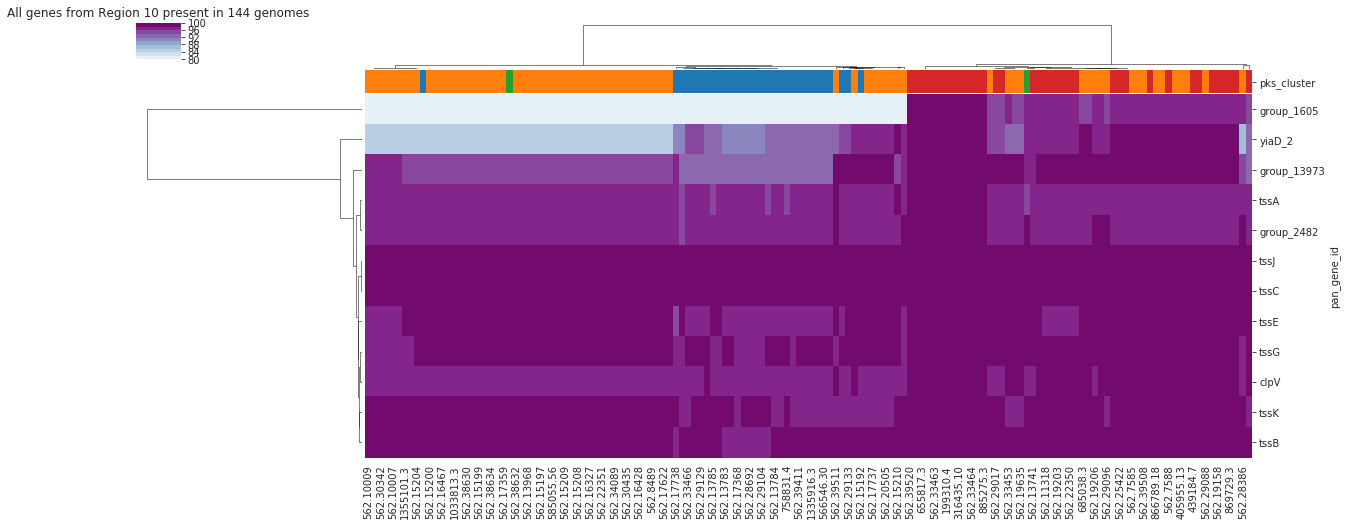

In [21]:
# T6SS additional gene inclusion in the figure : fig|1322345.19.peg.3502|DR76_3396
def include_extra_gene(df_homolog_pid_region_genomes, gene_id, df_homolog_pid):
    '''
    Add new gene to heatmap of T6SS region encoding PAAR repeats
    '''
    
    df_homolog_pid_region_genomes.loc[gene_id, :] = df_homolog_pid.loc[gene_id, df_homolog_pid_region_genomes.columns]
    
    return df_homolog_pid_region_genomes


def plot_pid_region_t6ss(df_homolog_pid_region_genomes, df_asso_genes, col_colors, fig_path,title_str):
    '''
    Plot heatmap of pid from BBH analysis for region of genes and genomes
    '''
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set_style('white')
    df_homolog_plot = df_homolog_pid_region_genomes.copy()

    df_homolog_plot.index = df_asso_genes.loc[df_homolog_plot.index, 'pan_gene_id']
    sns.clustermap(df_homolog_plot, cmap = sns.color_palette("BuPu",10), col_colors = col_colors, 
                           vmin = 80, vmax=100, figsize=(20,8))
    plt.title(title_str)
    plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
region_no = 10 
df_homolog_pid_region = slice_homolog_region(df_homolog_pid, df_asso_genes, region_no) 
df_homolog_pid_region_genomes = get_genomes_with_region(df_homolog_pid_region, bbh_cutoff = 50)
df_homolog_pid_region_genomes = include_extra_gene(df_homolog_pid_region_genomes, 'fig|1322345.19.peg.3502|DR76_3396', 
                                                   df_homolog_pid)
col_colors = get_col_colors(pickle_paths, df_homolog_pid_region_genomes)
fig_path = '../figures/raw/region_bbh_dist/region_' + str(region_no) + '_pid_distribution.png'
title_str = 'All genes from Region ' + str(region_no)+ ' present in ' + str(df_homolog_pid_region_genomes.shape[1]) + ' genomes'
plot_pid_region_t6ss(df_homolog_pid_region_genomes, df_asso_genes, col_colors, fig_path, title_str)

In [ ]:
# for tmp_cnt in range(len(gene_id_list)):
#     gene_id = gene_id_list[tmp_cnt]
#     gene_id_name = gene_id_name_list[tmp_cnt]
#     genome_ids_gene = df_asso_genes_homolog_bool.columns[df_asso_genes_homolog_bool.loc[gene_id,:] == 1]

    
#     if not os.path.isdir(os.path.join(gene_align_path, gene_id_name)):
#         os.mkdir(os.path.join(gene_align_path, gene_id_name))
#     gene_align_faa_path = os.path.join(gene_align_path, gene_id_name,'sequences.fa')

#     new_record_list = []

#     for pat_id in genome_ids_gene:
#         bbh_path = os.path.join(homolog_dir, pat_id, 'temp_target_BBH_dict.txt')
#         df_tmp_bbh = pd.read_table(bbh_path, header=None)
#         df_tmp_bbh.set_index(0,inplace=True)

#         tgt_gene_homologs = df_tmp_bbh.loc[gene_id, 1]
#         tgt_gene_homologs = tgt_gene_homologs[2:-2]

#         if ',' in tgt_gene_homologs:
#             tgt_gene_homologs = tgt_gene_homologs.replace("\'", "")

#             tgt_gene_homologs_list = tgt_gene_homologs.split(',')
#         else:
#             tgt_gene_homologs_list = [tgt_gene_homologs]

#         faa_path = os.path.join(data_dir, pat_id, pat_id + '.PATRIC.faa')

#         for record in SeqIO.parse(faa_path, "fasta"):
#             id_tgt = record.id
#             for gene_tgt_id in tgt_gene_homologs_list:
#                 if id_tgt == gene_tgt_id:
#                     new_record_list.append(record)

#     SeqIO.write(new_record_list, gene_align_faa_path, "fasta")
    
#     cline = MuscleCommandline(input=gene_align_faa_path)
#     cline = ClustalwCommandline("clustalw", infile=gene_align_faa_path)

#     stdout, stderr = cline()